In [2]:
import pandas as pd
import datetime as dt

In [3]:
dfy = pd.read_csv("./data/y.csv", index_col=0)
dfx = pd.read_excel("./data/compsaa_file2_20200701_20201231.xlsx").loc[lambda d: d.total_comment_num.notnull()]


c:\Users\evan\development\eda\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
convert_y_dates = lambda st: dt.datetime.strptime(st, "%Y-%m-%d")
convert_x_dates = lambda i: dt.datetime.strptime( str(i), "%Y%m%d.0")

In [5]:
dfx = dfx.assign(date_joiner=lambda d: d.date_key.apply(convert_x_dates))
dfy = dfy.assign(date_joiner=lambda d: d.date_time.apply(convert_y_dates))

In [6]:
dfy.head()

,date_time,product_name,sku,brand,deal_num,to_cart_num,date_joiner
0,2020-01-01,美素佳儿（Friso）儿童配方奶粉 4段（3岁以上至6岁适用）900克（荷兰原装进口）,100004774814,美素佳儿（Friso）,0,4,2020-01-01
1,2020-01-01,美素佳儿（Friso Prestige）皇家儿童配方奶粉 4段（3岁以上至6岁适用） 800...,100006224968,美素佳儿（Friso）,0,3,2020-01-01
2,2020-01-01,美素力（Frisolac Prestige）皇家婴儿配方奶粉 1段（0-6个月婴儿适用） 4...,100007187818,美素佳儿（Friso）,0,3,2020-01-01
3,2020-01-01,美素佳儿（Friso）较大婴儿配方奶粉 2段（6-12个月婴幼儿适用）1200克（荷兰原装进口）,100004188413,美素佳儿（Friso）,0,5,2020-01-01
4,2020-01-01,美素佳儿（Friso）幼儿配方奶粉 3段（1-3岁幼儿适用）900克（新客礼）,100003754072,美素佳儿（Friso）,0,2,2020-01-01


In [7]:
dfx.head()

,sku,product_name,monthly_sales_qty,total_sales_qty,total_comment_num,date_key,date_joiner
0,100021558806,爱尔兰原装进口 爱他美（Aptamil）英国HMO较大婴儿配方奶粉2段（6-12个月）易乐罐...,NaN,NaN,7.0,20211005.0,2021-10-05
1,10022644635456,【现货】美国Edward & Sons有 机椰丝烘焙227g,NaN,NaN,0.0,20201225.0,2020-12-25
3,43541408544,京东超市 合生元 爱斯时光 1段400g 婴儿配方奶粉0-6个月 原罐进口,NaN,NaN,697.0,20211102.0,2021-11-02
4,55514902865,【送礼礼盒】蒙牛金装铂金装中老年/学生/成人多维高钙成人奶粉2罐装 送长辈父母孩子营养奶粉 ...,NaN,NaN,169.0,20210508.0,2021-05-08
7,7425800,雅培(Abbott)Eleva菁挚纯净幼儿配方奶粉 3段900克*3 天然纯净礼盒（新老包装...,NaN,NaN,7178.0,20211019.0,2021-10-19


Intersection of skus across datasets:

In [8]:
sku_overlaps = set(dfx.sku).intersection(set(dfy.sku))
print(f"unique number of sku id's across datasets = {len(sku_overlaps)}")

unique number of sku id's across datasets = 163


Intersection of product names across datasets

In [9]:
name_overlaps = set(dfx.product_name).intersection(set(dfy.product_name))
print(f"unique number of sku id's across datasets = {len(name_overlaps)}")

unique number of sku id's across datasets = 82


In [10]:
#overlapped_sku = sku_overlaps.pop()

In [11]:
dfx.loc[lambda dd: dd.loc[lambda d: d.sku.isin(sku_overlaps)].total_comment_num.notnull().loc[lambda x: x].index].sku.value_counts()

100003254211    27
100002643949    27
100005794930    25
100004404957    24
100005855583    23
                ..
100017132980     1
100003754072     1
100017379210     1
100016053346     1
100017879356     1
Name: sku, Length: 163, dtype: int64

Example SKU = 100004404957

<AxesSubplot:xlabel='date_joiner'>

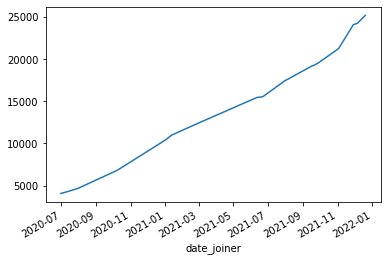

In [12]:
dfx.loc[lambda d: d.sku == 100005855583].set_index('date_joiner').sort_index().total_comment_num.plot()#.total_comment_num

<AxesSubplot:xlabel='date_joiner'>

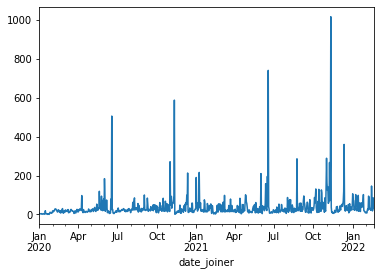

In [92]:
dfy.loc[lambda d: d.sku == 100005855583].groupby(['sku', 'date_joiner'])['deal_num'].max().droplevel(0).plot()

## Hypothesis 1

`tcd-0030` is correlated to sales (compass/GP#232)

### `tcd-0030` definition
take a random observation of all-comments, at time `t_0`. 

1. find the closest observation of `tc` to that time, call it `tc_m30`.  
2. then, compute the number of days that `tc_m30` is away from `t_0 - 30d`, and call it `tc-delta-m30`
3. last, compute the difference between `tc` and `tc_m30`, call it `tcd-0030`

In [45]:
from datetime import timedelta
from matplotlib import pyplot as plt
import numpy as np

In [15]:
x_sers = dfx.loc[lambda d: d.sku == 100005855583].set_index('date_joiner').sort_index().total_comment_num.copy()
display(x_sers)

date_joiner
2020-07-01     4078.0
2020-07-10     4245.0
2020-07-31     4676.0
2020-10-09     6842.0
2021-01-02    10436.0
2021-01-12    10975.0
2021-03-02    12450.0
2021-03-07    12599.0
2021-06-12    15447.0
2021-06-13    15449.0
2021-06-22    15527.0
2021-08-01    17464.0
2021-08-03    17522.0
2021-09-18    19212.0
2021-09-21    19256.0
2021-09-25    19424.0
2021-09-26    19451.0
2021-09-29    19574.0
2021-11-03    21238.0
2021-11-29    24064.0
2021-12-04    24178.0
2021-12-06    24230.0
2021-12-20    25158.0
Name: total_comment_num, dtype: float64

In [20]:
## in the above case, there are several values to choose.  let's try doing this by month.
# reduce the data to observations separated by month, to avoid over-correlating the observations.


def compute_tcd00m(x_df: pd.DataFrame, 
                   m=20,
                   sku_col = "sku",
                   tc_col = "total_comment_num",
                   ) -> pd.DataFrame:
    """Take series of relevant products to compute `tcd-00{m}`.

    expected input:
        pd.DataFrame:
            columns = *_col
            datetime index

    start with tcd-0020, but, may need to try.. 
      - tcd-0030
      - tcd-0040
      - tcd-0050
      - tcd-0060
    """


    assert sku_col in x_df.columns
    assert tc_col in x_df.columns
    # add assert for time series index?

    sku_num = x_df.loc[:, sku_col].iat[0]

    last_ts, tcs, tss, tc_deltas, tcd_0030s = None, [], [], [], []
    min_time_between_obs = timedelta(days=m)

    for ts, tc in x_df.loc[:, tc_col].iteritems():
        if not last_ts:
            last_ts, last_tc = ts, tc
            continue

        time_between_obs = ts - last_ts

        if time_between_obs > min_time_between_obs:
            tcs.append(tc)
            tss.append(ts)
            tc_deltas.append(time_between_obs-min_time_between_obs)
            tcd_0030s.append(tc - last_tc)
            last_ts, last_tc = ts, tc

    output = {"tcs": tcs,
              "tss": tss,
              "tc_deltas": tc_deltas,
              f"tcd_00{m:02d}s": tcd_0030s,
              "sku": sku_num}

    return pd.DataFrame(output).set_index(['sku', 'tss'])



In [57]:
M=30
X=f"tcd_00{M:02d}s"
y=f"dealnum{M:02d}"

In [ ]:

compute_tcd00m(dfx.loc[lambda d: d.sku == 100005855583].set_index('date_joiner').sort_index(), m=M)

In [21]:
feature_dfs = []
subset_df = lambda dd, idx: dfx.loc[lambda d: d.sku == idx].set_index('date_joiner').sort_index()

dfa = pd.concat([dfx.pipe(subset_df, idx=sku).pipe(compute_tcd00m, m=M) 
                 for sku in sku_overlaps])



In [24]:
reduced_y = (dfy
     .loc[lambda d: d.sku.isin(sku_overlaps)]  # this part is the key-- for compute
     .rename(columns={"date_joiner": "tss"})
     .groupby(['sku', 'tss'])['deal_num']  # there are weird dups in the y data.. possible need to investigate
     .max()
     .sort_index()
     )

In [26]:
def m_shifter(data, col, m=20):
    return data.assign(**{f"{col}_{i:02d}": data.loc[:, col].shift(i) for i in range(1, m)})


In [27]:
agg_y = (reduced_y
        .to_frame()
        .pipe(m_shifter, col="deal_num", m=M)
        .assign(**{f"dealnum{M:02d}": lambda d: d.sum(axis=1)})
        .loc[:, f"dealnum{M:02d}"]
        )

In [29]:
agg_y

sku           tss       
2112715       2020-01-01    102.0
              2020-01-02    125.0
              2020-01-03    129.0
              2020-01-04    181.0
              2020-01-05    199.0
                            ...  
100026817154  2022-02-13      0.0
              2022-02-15      0.0
              2022-02-16      0.0
              2022-02-17      0.0
              2022-02-18      0.0
Name: dealnum30, Length: 85347, dtype: float64

In [30]:
df_final = dfa.join(agg_y)

<Figure size 504x504 with 0 Axes>

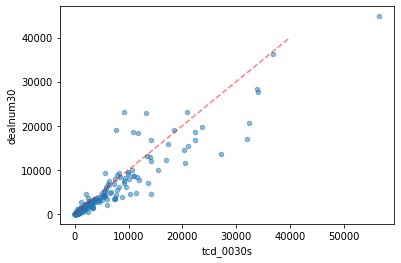

In [40]:
plt.figure(figsize=(7,7))
(df_final
 .loc[lambda d: d.tc_deltas < timedelta(days=20)]
 .plot(kind="scatter", y=f"dealnum{M:02d}", x=f"tcd_00{M:02d}s", alpha=0.5)
)
plt.plot([0,4e4], [0,4e4], 'r--', alpha=.5)

In [53]:
df_final.head()

tcs tc_deltas  tcd_0030s  dealnum30
sku          tss                                               
100013241352 2021-01-12  1026.0  106 days      838.0      189.0
             2021-03-29  1445.0   46 days      419.0      205.0
             2021-08-24  2247.0  118 days      802.0      135.0
             2021-09-25  2369.0    2 days      122.0      126.0
             2021-11-02  2474.0    8 days      105.0       78.0

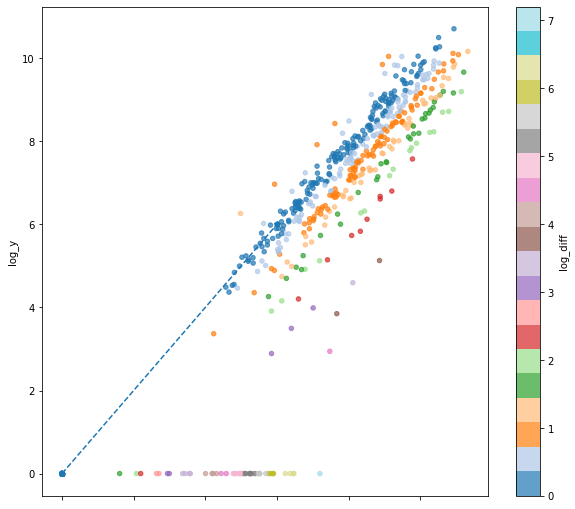

In [95]:
(df_final
 .sort_values(by="tc_deltas")
 .assign(log_x=lambda d: d.loc[:, X].apply(np.log1p),
         log_y=lambda d: d.loc[:, y].apply(np.log1p),
         log_diff=lambda d: abs(d.log_x - d.log_y),
         time_delay=lambda d: d.loc[:, "tc_deltas"].apply(lambda x: x.days),
         )
 .loc[:, ["time_delay", X, y, "log_x","log_y","log_diff"]]
 #.style.bar()
 .plot(x="log_x",
       y="log_y",
       c="log_diff",
       cmap="tab20",
       alpha=.7,
       kind='scatter',
       #xlim=(0,6e4),
       #ylim=(0,6e4),
       figsize=(10,9))
)
plt.plot([0,6], [0,6], 'p--')


In [79]:
df_final.loc[lambda d: d.loc[:, X] > 10000]

tcs tc_deltas  tcd_0030s  dealnum30
sku          tss                                                 
100005156931 2020-12-24   52400.0   87 days    16786.0     3162.0
100002005661 2021-01-03   94304.0   70 days    10035.0     2486.0
             2021-05-26  110805.0  113 days    16501.0     2379.0
2491139      2021-05-10   50273.0   21 days    24697.0    20295.0
             2021-06-12   67528.0    3 days    17255.0    15919.0
...                           ...       ...        ...        ...
6727647      2021-07-13  527480.0   92 days    40647.0    11354.0
             2021-09-14  545090.0   33 days    17610.0     6343.0
             2021-11-04  560083.0   21 days    14993.0    11974.0
100007805922 2021-01-12   55110.0   86 days    17783.0     1948.0
7721443      2021-06-17   33467.0  105 days    13823.0     9123.0

[135 rows x 4 columns]

In [63]:
timedelta(days=9).days

9